In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from bs4 import BeautifulSoup, SoupStrainer
import sys, string, requests, datetime, time
%matplotlib inline

In [2]:
players = pd.read_csv('Tables/players.csv')
players.head()

,name,active_from,active_to,birth_date,position,trad_position,ppg,trb,ast,height_inches,weight,shooting_hand,hof,college,hs_name,hs_city,hs_state,url
0,Alaa Abdelnaby,1991,1995,1968-06-24,Power Forward,Forward,5.7,3.3,0.3,82.0,240.0,Right,0.0,Duke University,Bloomfield,Bloomfield,New Jersey,/players/a/abdelal01.html
1,Zaid Abdul-Aziz,1969,1978,1946-04-07,Power Forward,Forward,9.0,8.0,1.2,81.0,235.0,Right,0.0,Iowa State University,John Jay,Brooklyn,New York,/players/a/abdulza01.html
2,Kareem Abdul-Jabbar,1970,1989,1947-04-16,Center,Center,24.6,11.2,3.6,86.0,225.0,Right,1.0,"University of California, Los Angeles",Power Memorial,New York,New York,/players/a/abdulka01.html
3,Mahmoud Abdul-Rauf,1991,2001,1969-03-09,Point Guard,Guard,14.6,1.9,3.5,73.0,162.0,Right,0.0,Louisiana State University,Gulfport,Gulfport,Mississippi,/players/a/abdulma02.html
4,Tariq Abdul-Wahad,1998,2003,1974-11-03,Shooting Guard,Guard,7.8,3.3,1.1,78.0,223.0,Right,0.0,"University of Michigan, San Jose State University",Lycee Aristide Briand,Evreux,France,/players/a/abdulta01.html


In [3]:
players_hof = players[players['hof'] == 1]
players_not_hof = players[players['hof'] == 0]

Here are the features from the dataframe:
- name: full name of player, first name and last name
- active_from: year started playing for the NBA
- active_to: last year playing for the NBA (2018 is still active)
- birth_date: datetime variable, date of birth
- position: five positions classification - most common approach in modern ear
- trad_position: three positions classification - traditional approach of describing positions
- ppg: float variable, total points per game
- trb: float variable, total rebounds per game
- ast: float variable, total assists per game
- height_inches: float variable, height measured in inches
- weight: float variable, weight measured in pounds
- shooting hand: prefered shooting hand
- hof: inducted into Naismith Memorial Basketball Hall of Fame as player
- college: college basketball programs of participation
- hs_name: name of high school attended
- hs_city: city of high school location
- hs_state: state or country (if foreign player) of high school
- url: player page in www.basketball-reference.com

## Data visualization

### Individual statistics

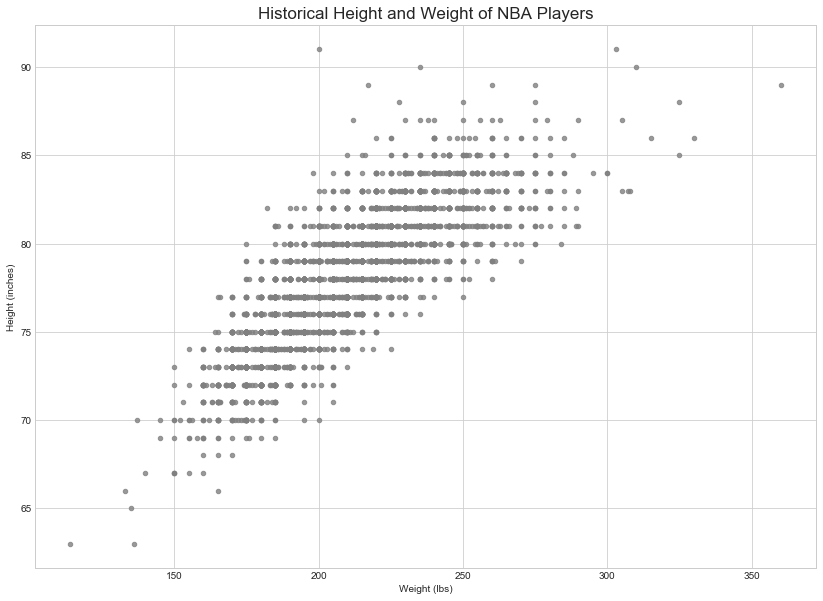

In [4]:
plt.figure(figsize=(14,10))

ax = sns.regplot(x='weight', y='height_inches', data=players, 
                 color='grey', fit_reg=False, scatter_kws={"s": 20})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')
plt.rcParams["axes.labelsize"] = 15
plt.title('Historical Height and Weight of NBA Players', fontsize=17)

plt.savefig('all-graphs/height_weight.png')

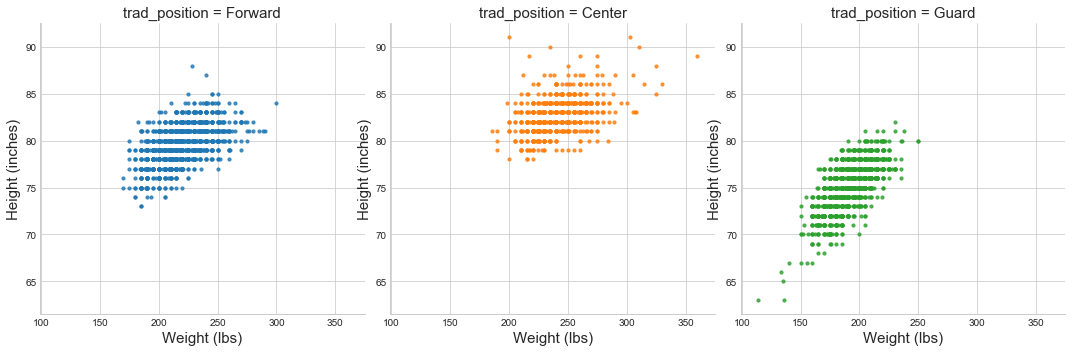

In [5]:
ax = sns.lmplot(x="weight", y="height_inches", data=players, 
               col='trad_position', hue='trad_position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 10})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')

plt.savefig('all-graphs/height_weight_3pos.png')

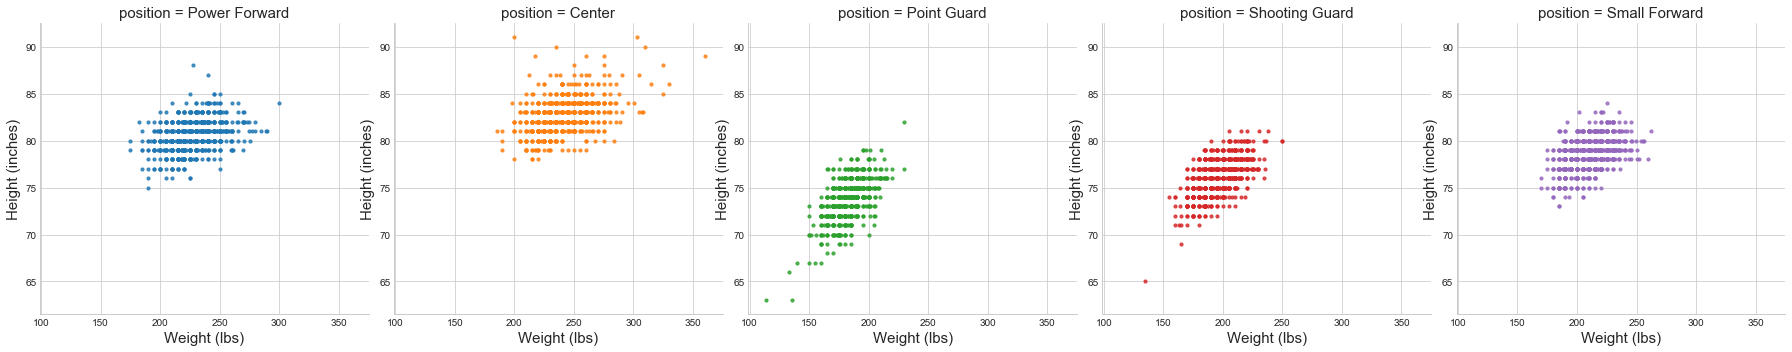

In [6]:
ax = sns.lmplot(x="weight", y="height_inches", data=players, 
               col='position', hue='position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 10})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')

plt.savefig('all-graphs/height_weight_5pos.png')

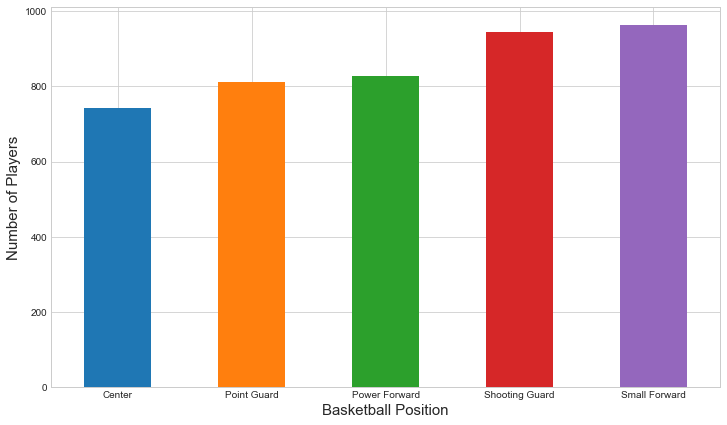

In [7]:
ax = players.groupby('position').count()['trad_position'].plot.bar(figsize=(12,7), rot=0)
ax.set(xlabel='Basketball Position', ylabel='Number of Players')

plt.savefig('all-graphs/num_pos.png')

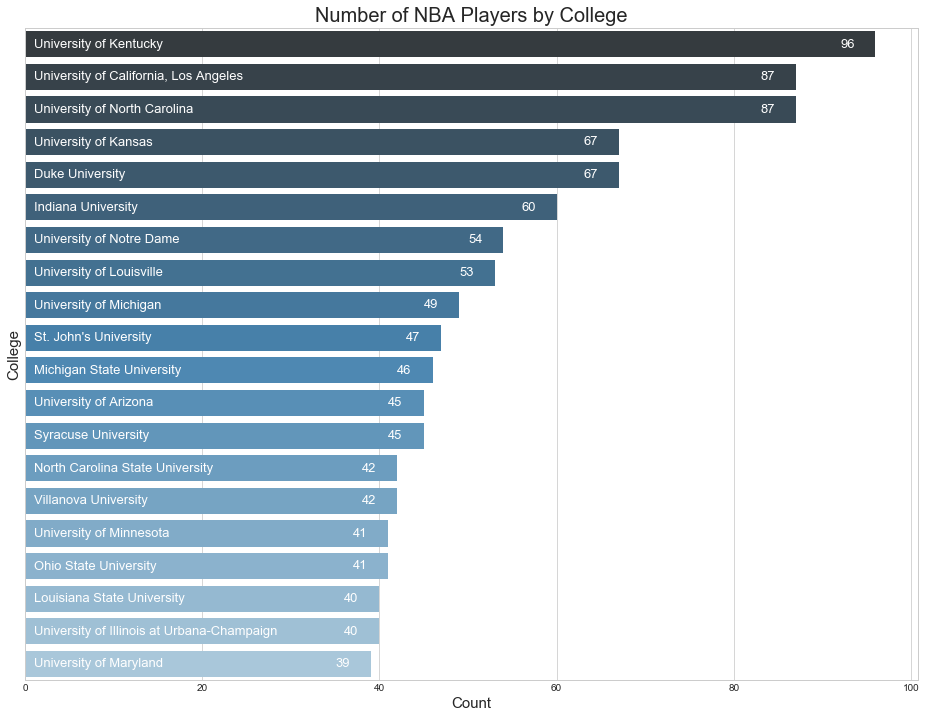

In [8]:
top_colleges = players['college'].value_counts()[:20]
top_colleges_df = pd.DataFrame(top_colleges)
top_colleges_df.columns = ['Count']

plt.figure(figsize=(16,12))
sns.barplot(x='Count', y=top_colleges_df.index, data=top_colleges_df, palette="Blues_d")
plt.title('Number of NBA Players by College', fontsize=20)
plt.ylabel('College', fontsize=15)
plt.gca().set_yticks([]);

for num in range(len(top_colleges)):
    plt.text(top_colleges[num]-4, num, top_colleges[num], color='white', size=13, verticalalignment='center')
    plt.text(1, num, top_colleges.index[num], color='white', size=13, verticalalignment='center')
    
plt.savefig('all-graphs/top_colleges.png')

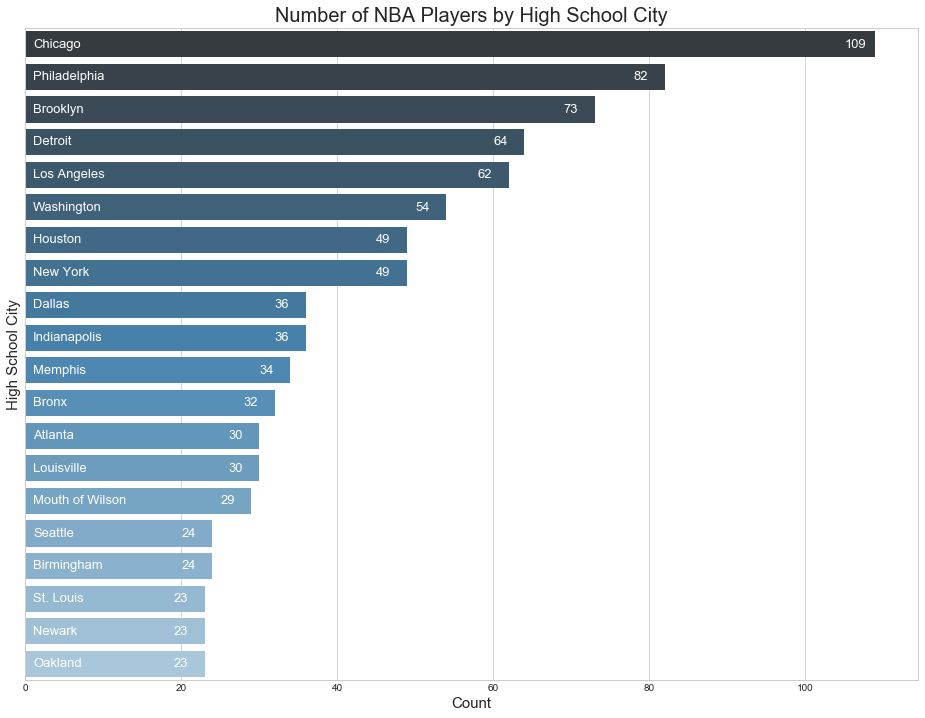

In [9]:
top_hs_cities = players['hs_city'].value_counts()[:20]
top_hs_cities_df = pd.DataFrame(top_hs_cities)
top_hs_cities_df.columns = ['Count']

plt.figure(figsize=(16,12))
sns.barplot(x='Count', y=top_hs_cities_df.index, data=top_hs_cities_df, palette="Blues_d")
plt.title('Number of NBA Players by High School City', fontsize=20)
plt.ylabel('High School City', fontsize=15)
plt.gca().set_yticks([]);

for num in range(len(top_hs_cities)):
    plt.text(top_hs_cities[num]-4, num, top_hs_cities[num], color='white', size=13, verticalalignment='center')
    plt.text(1, num, top_hs_cities.index[num], color='white', size=13, verticalalignment='center')
    
plt.savefig('all-graphs/top_hs_city.png')

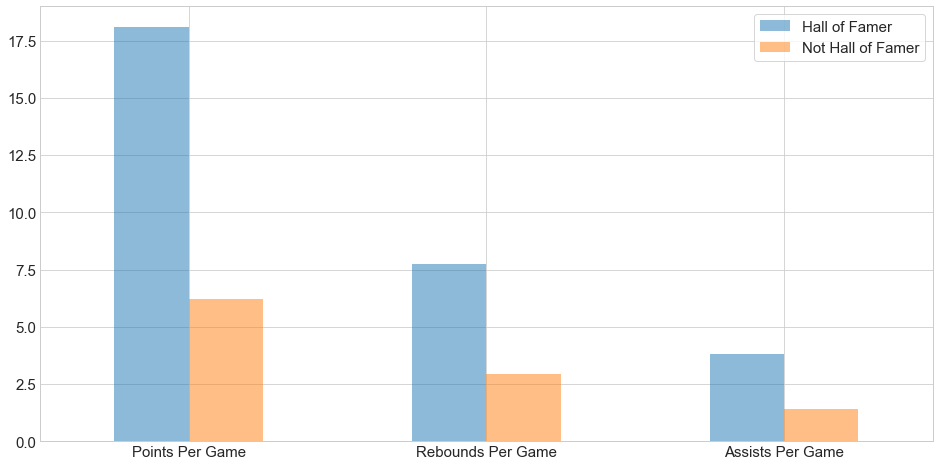

In [42]:
sort_by_hof = players.groupby('hof')['ppg', 'trb', 'ast'] # statistics grouped by hof status
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({'ppg': 'Points Per Game', 
                                  'trb': 'Rebounds Per Game', 
                                  'ast': 'Assists Per Game'}, 
                                   axis='index')
sort_by_hof = sort_by_hof.rename({1: 'Hall of Famer', 
                                  0: 'Not Hall of Famer'}, 
                                  axis='columns')
sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('all-graphs/hof_stats.png')

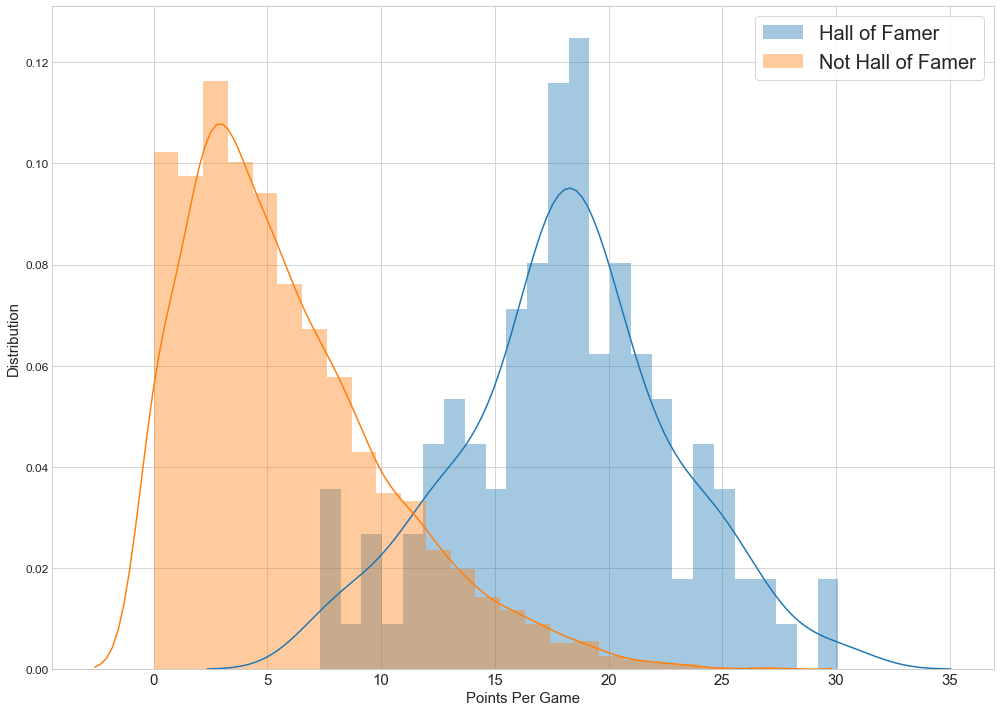

In [11]:
plt.figure(figsize=(14,10))
sns.distplot(players_hof['ppg'], bins=25, label='Hall of Famer')
sns.distplot(players_not_hof['ppg'].fillna(0), bins=25, label='Not Hall of Famer')

plt.legend(loc=1, frameon=True, prop={'size': 20})
plt.xlabel("Points Per Game")
plt.ylabel("Distribution")
plt.yticks(fontsize=12)
plt.xticks(fontsize=15)
plt.tight_layout()

plt.savefig('all-graphs/hof_ppg.png')

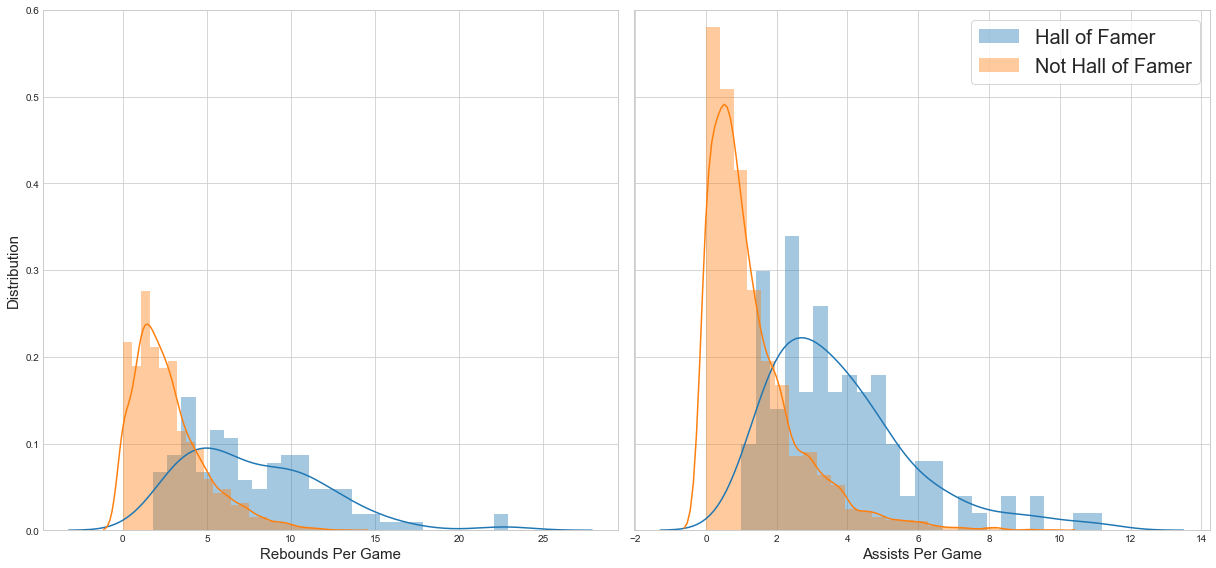

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(17,8))

sns.distplot(players_hof['trb'], bins=25, label='Hall of Famer', ax=ax1)
sns.distplot(players_not_hof['trb'].fillna(0), bins=25, label='Not Hall of Famer', ax=ax1)
ax1.set(xlabel='Rebounds Per Game', ylabel='Distribution')
plt.xticks(fontsize=27)

sns.distplot(players_hof['ast'], bins=25, label='Hall of Famer', ax=ax2)
sns.distplot(players_not_hof['ast'].fillna(0), bins=25, label='Not Hall of Famer', ax=ax2)
ax2.set(xlabel='Assists Per Game')

plt.legend(loc=1, frameon=True, prop={'size': 20})
plt.ylim(0, 0.6)
plt.xticks(fontsize=10)
plt.tight_layout()

plt.savefig('all-graphs/hof_trb_ast.png')

## Model data for Machine Learning regression

In [13]:
players_feat = players[['position', 'trad_position', 'ppg', 'trb', 'ast', 
                        'height_inches', 'weight', 'hof']].copy()

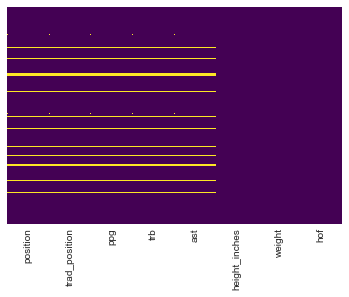

In [14]:
sns.heatmap(players_feat.isnull(), yticklabels=False, cbar=False, cmap='viridis')

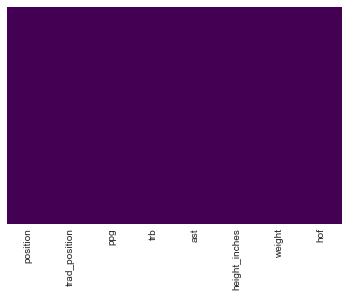

In [15]:
players_feat = players_feat.dropna() # delete rows with NaN values
sns.heatmap(players_feat.isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### Basketball positions are also numbered starting with the point guard:
- 1: floor general (point guard, combo guard)
- 2: wing (shooting guard, guard-forward, swingman)
- 3: wing (small forward, point forward)
- 4: post (power forward, stretch four, combo forward)
- 5: pivot (center, forward-center)

Often coaches and players will call the positions by numbers stead of names, especially for players who can play both positions. For example, a player who has the attributes of a point guard (1) and shooting guard (2) and can play both positions are sometimes called combo guard (1-2 guard). The numbers also correspond to weight/height of a player (as seen above) and their playing styles (higher number typically means more rebounds and less assists). We can convert the position (string values) in a pandas dataframe to a unique integer (pos_num) so that the algorithms can better perform.

In [16]:
players_feat['pos_num'] = players_feat['position'].map({'Point Guard': 1,
                                                       'Shooting Guard': 2,
                                                       'Small Forward': 3,
                                                       'Power Forward': 4,
                                                       'Center': 5})

In [17]:
players_feat.head()

,position,trad_position,ppg,trb,ast,height_inches,weight,hof,pos_num
0,Power Forward,Forward,5.7,3.3,0.3,82.0,240.0,0.0,4
1,Power Forward,Forward,9.0,8.0,1.2,81.0,235.0,0.0,4
2,Center,Center,24.6,11.2,3.6,86.0,225.0,1.0,5
3,Point Guard,Guard,14.6,1.9,3.5,73.0,162.0,0.0,1
4,Shooting Guard,Guard,7.8,3.3,1.1,78.0,223.0,0.0,2


## Model data for Machine Learning regression

### Position Number (1 - 5)

In [18]:
from sklearn.model_selection import train_test_split
X = players_feat[['ppg', 'trb', 'ast', 'height_inches', 'weight']]
y = players_feat['pos_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Linear Regression Model</font>

In [19]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

# print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.8008344647854284


<font color='blue'>SVR (non-linear regression model)</font>

In [20]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

# print(svr.score(X_train, y_train))
print(svr.score(X_test, y_test))

0.7146249994309386


### Modern Five Positions

In [21]:
X = players_feat[['ppg', 'trb', 'ast', 'height_inches', 'weight']]
y = players_feat['position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression Model</font>

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

                precision    recall  f1-score   support

        Center       0.63      0.67      0.65       235
   Point Guard       0.70      0.76      0.73       253
 Power Forward       0.37      0.32      0.34       209
Shooting Guard       0.54      0.55      0.55       290
 Small Forward       0.54      0.52      0.53       299

   avg / total       0.56      0.57      0.56      1286



[[157   0  54   5  19]
 [  0 193   1  54   5]
 [ 74   0  67   7  61]
 [  0  76   6 159  49]
 [ 17   7  52  68 155]]


<font color='blue'>Decision Tree Classifier</font>

In [23]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

                precision    recall  f1-score   support

        Center       0.72      0.65      0.68       235
   Point Guard       0.67      0.70      0.68       253
 Power Forward       0.38      0.44      0.41       209
Shooting Guard       0.52      0.50      0.51       290
 Small Forward       0.52      0.50      0.51       299

   avg / total       0.56      0.56      0.56      1286



[[152   0  68   2  13]
 [  0 176   1  68   8]
 [ 51   1  92   7  58]
 [  0  77   9 145  59]
 [  7  10  75  57 150]]


<font color='blue'>Naive Bayse Classifier</font>

In [24]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

                precision    recall  f1-score   support

        Center       0.81      0.62      0.70       235
   Point Guard       0.75      0.75      0.75       253
 Power Forward       0.46      0.59      0.52       209
Shooting Guard       0.58      0.56      0.57       290
 Small Forward       0.59      0.61      0.60       299

   avg / total       0.64      0.62      0.63      1286



[[145   0  78   0  12]
 [  0 189   0  62   2]
 [ 34   0 123   2  50]
 [  0  60   5 161  64]
 [  1   4  61  51 182]]


### Traditional Three Positions

In [25]:
X = players_feat[['ppg', 'trb', 'ast', 'height_inches', 'weight']]
y = players_feat['trad_position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression Model</font>

In [26]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.68      0.34      0.46       208
    Forward       0.71      0.79      0.74       556
      Guard       0.85      0.91      0.88       522

avg / total       0.76      0.77      0.75      1286



[[ 71 137   0]
 [ 33 437  86]
 [  0  45 477]]


<font color='blue'>Decision Tree Classifier</font>

In [27]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.62      0.70      0.66       208
    Forward       0.73      0.72      0.72       556
      Guard       0.86      0.83      0.84       522

avg / total       0.76      0.76      0.76      1286



[[146  62   0]
 [ 86 400  70]
 [  4  86 432]]


<font color='blue'>Naive Bayse Classifier</font>

In [28]:
model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.75      0.76      0.76       208
    Forward       0.81      0.81      0.81       556
      Guard       0.90      0.89      0.90       522

avg / total       0.84      0.84      0.84      1286



[[159  49   0]
 [ 54 450  52]
 [  0  55 467]]


### Predicting hall of fame status
#### By points per game, total rebounds per game, and assists per game

In [29]:
X = players_feat[['ppg', 'trb', 'ast']]
y = players_feat['hof']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [30]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99      1242
        1.0       0.74      0.39      0.51        44

avg / total       0.97      0.97      0.97      1286



[[1236    6]
 [  27   17]]


In [31]:
LBJ = pd.DataFrame({'ppg': [27], 'trb': [7], 'ast': [7]})
predictions = logmodel.predict(LBJ)
predictions

array([1.])

In [43]:
lb = players[players['name'] == 'LeBron James'][['ppg', 'trb', 'ast']]
players[['ppg', 'trb', 'ast']].dropna().head(10)

,ppg,trb,ast
0,5.7,3.3,0.3
1,9.0,8.0,1.2
2,24.6,11.2,3.6
3,14.6,1.9,3.5
4,7.8,3.3,1.1
5,18.1,7.5,2.5
6,5.6,3.2,1.2
7,0.0,1.0,1.0
9,5.3,1.4,0.5
10,2.7,1.0,0.5


### Year-by-year statistics

In [33]:
left = []
right = []
height = []
weight = []
ppg = []
trb = []
ast = []

start = players.active_from.min()
end = players.active_from.max()

for year in range(start,end):
    active = (players.active_from.values <= year) & (players.active_to >= year) # only include active players
    height.append(np.mean(players[active].height_inches)) # average height in inches
    weight.append(np.mean(players[active].weight)) # average weight in pounds
    left.append(1.0*np.sum(players[active].shooting_hand == 'Left')) # number of left handed shooters
    right.append(1.0*np.sum(players[active].shooting_hand == 'Right')) # number of right handed shooters
    ppg.append(np.mean(players[active].ppg))
    trb.append(np.mean(players[active].trb))
    ast.append(np.mean(players[active].ast))
    
# create a DataFrame with a summary
stats_year = pd.DataFrame({'season': np.arange(start,end), 
                          'height': height,
                          'weight': weight,
                          'left': left,
                          'right': right,
                          'ppg': ppg,
                          'trb': trb,
                          'ast': ast}).set_index('season')

# preview
stats_year.head()

,ast,height,left,ppg,right,trb,weight
season,,,,,,,
1947,1.721739,74.322981,1.0,9.339130,22.0,3.791304,188.656250
1948,1.925000,74.570175,1.0,8.993750,31.0,3.671875,187.362832
1949,1.944444,75.197740,3.0,8.674603,60.0,3.974603,191.536723
1950,2.021138,75.324444,5.0,8.518699,118.0,4.040650,191.493274
1951,1.930065,75.843137,6.0,8.183660,147.0,3.984314,194.549020


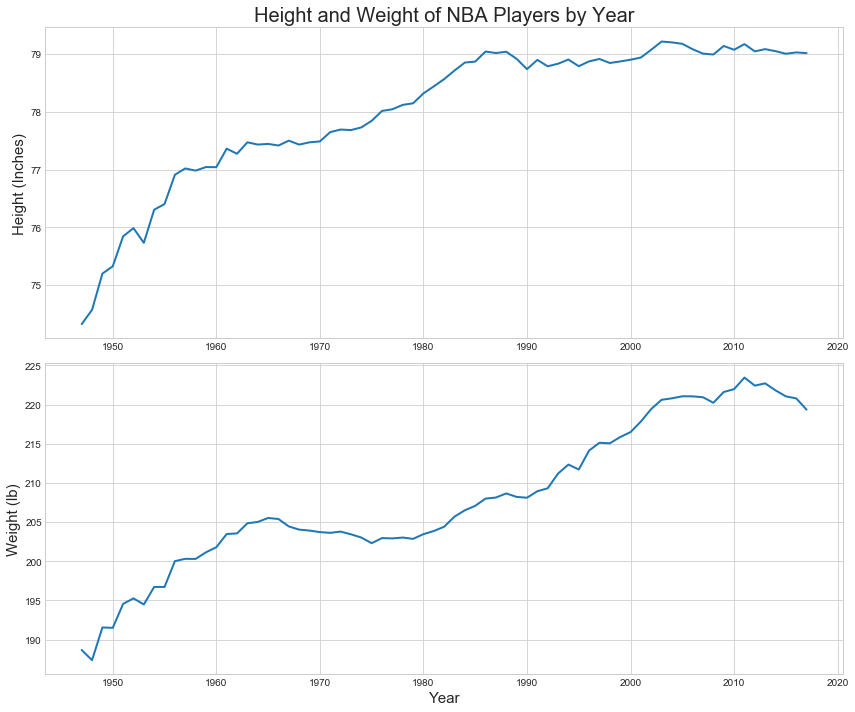

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

plt.subplot(2, 1, 1)
plt.title('Height and Weight of NBA Players by Year', fontsize = 20)
plt.plot(stats_year['height'], linewidth=2.0)
plt.ylabel("Height (Inches)", fontsize=15)


plt.subplot(2, 1, 2)
plt.plot(stats_year['weight'], linewidth=2.0)
plt.ylabel('Weight (lb)', fontsize=15)
plt.xlabel('Year', fontsize=15)

plt.tight_layout()
plt.savefig('all-graphs/yoy_weight_weight.png')

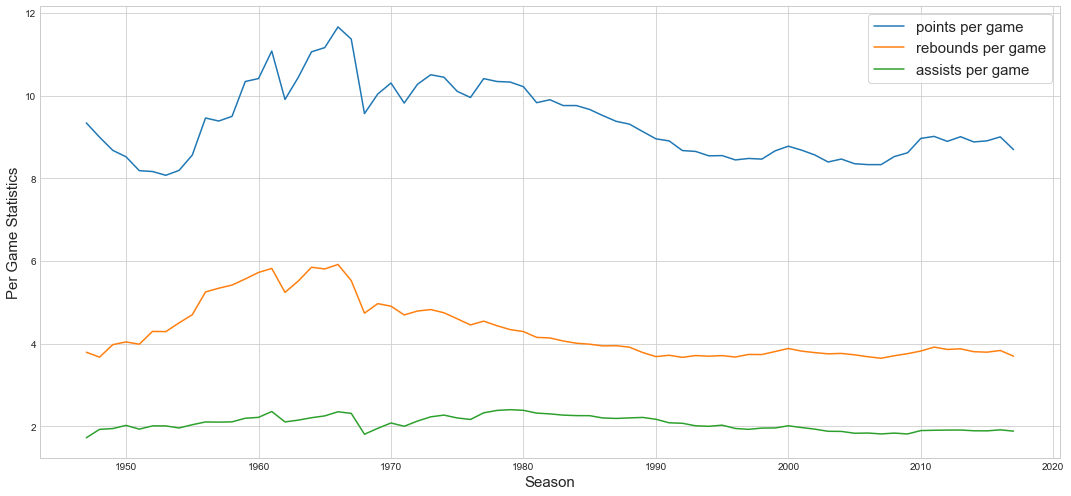

In [35]:
stats_year['ppg'].plot(figsize=(15,7), label='points per game')
stats_year['trb'].plot(label='rebounds per game')
stats_year['ast'].plot(label='assists per game')

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Season")
plt.ylabel("Per Game Statistics")
plt.tight_layout()

plt.savefig('all-graphs/yoy_ppg_trb_ast.png')

### Predicting points-per-game by year

In [36]:
X = stats_year.drop('ppg', axis=1)
y = stats_year['ppg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Linear Regression Model</font>

In [37]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print("R2 Score: ", lm.score(X_test, y_test))

R2 Score:  0.825460365385929


In [38]:
predictions

array([11.13923936,  9.09531032, 10.67595122,  9.05706648,  8.80827795,
        8.36189828,  9.09526312,  8.44583606,  8.32440701,  8.04931118,
        9.72559408,  9.30958656,  9.7406825 , 10.59670243, 10.10896822,
        8.88081908,  8.87527556,  8.93733118,  8.35591791,  9.27692657,
       10.3225838 ,  9.11974342])

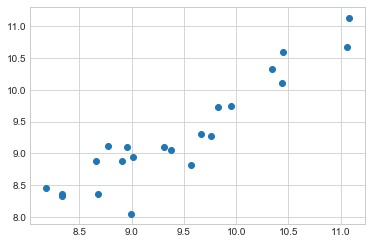

In [39]:
plt.scatter(y_test, predictions) ## y_test contains the contain ppg averages year-by-year

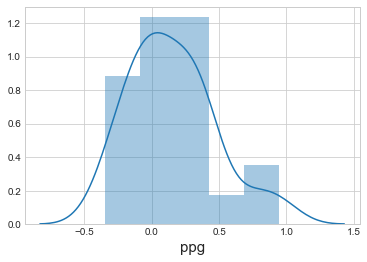

In [40]:
sns.distplot(y_test - predictions) # histogram of the residuals